2D image (width, height) ==> (width * features * resolution, height)

In [89]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import pdb
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import random
from scipy.ndimage.filters import gaussian_filter
from skimage.draw import line_aa
%matplotlib inline

from scipy.stats import norm

device = "cuda" if torch.cuda.is_available() else "cpu"

class NormalDistributionCollection(object):
    def __init__(self, resolution, var=0.07):
        self.gaussians = torch.stack([self.normal_distribution(resolution, index.item() / resolution, var) for index in np.arange(resolution)])

    @staticmethod
    def normal_distribution(n, mean, var=0.05):
      x = norm.pdf(np.arange(0, 1, 1.0 / n), mean, var)
      x = x / np.max(x)
      return torch.tensor(x).float()

    @staticmethod
    def to_pdf(frames):
        element_count = np.prod(frames.shape)
        frames_shape = frames.shape
        frames_view = frames.contiguous().view((element_count,))
        frames_pdf = torch.stack([NormalDistributionCollection.normal_distribution(resolution, mean.item()) for mean in frames_view])
        frames_pdf = frames_pdf.view(frames_shape[:-1] + (frames_shape[-1] * resolution, ))
        return frames_pdf


def generate_frames1(width, height):
    frames = []
    for _ in range(100):
        frame = np.zeros((width, height))
        rr, cc, val = line_aa(random.randint(0, height-1), random.randint(0, width-1), random.randint(0, height-1), random.randint(0, width-1))
        frame[rr, cc] = val
        frame=gaussian_filter(frame, 0.5)
        frames.append(frame)

    return torch.as_tensor(frames).to(device)

def generate_frames(width, height):
    return torch.as_tensor([[[0, 0], [1, 1]], [[1, 1], [0, 0]]])
    
def show_image(image, vmin=None, vmax=None, title=None, print_values=False):
    #print("image ", image.shape)
    fig, ax1 = plt.subplots(figsize=(6, 2))
    if title:
        plt.title(title)
    #i = image.reshape((height, width))
    #print("i ", i.shape)
    ax1.imshow(image, vmin=vmin, vmax=vmax)
    plt.show()
    if print_values:
        print(image)
        
class Encoder(torch.nn.Module): 
  
    def __init__(self, out_channels, resolution, kernel_size=4):
        super().__init__() 
        self.e1 = nn.Conv2d(in_channels=1, out_channels=out_channels, kernel_size=(kernel_size, kernel_size*resolution), stride=(2, 2*resolution)).to(device)
        self.bn1 = nn.BatchNorm2d(out_channels).to(device)
        #self.pool1 = nn.MaxPool2d(2).to(device)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = x[:, None, :, :]  # assume 1 feature
        x = self.e1(x)
        x = self.bn1(x)
        #x = self.pool1(x)
        x = self.tanh(x)
        return x

class Decoder(torch.nn.Module): 
  
    def __init__(self, height, width, resolution):
        super().__init__() 
        self.height = height
        self.width = width
        self.resolution = resolution
        #self.tanh = nn.Tanh()
        self.relu = nn.ReLU()
        self.d1 = None
  
    def forward(self, z):
        if len(z.shape) > 2:
            z = z.view(z.shape[0], -1)
        
        if self.d1 is None:
            print("z ", z.shape)
            print("self.height * self.width * self.resolution ", self.height * self.width * self.resolution)
            self.d1 = nn.Linear(z.shape[-1], self.height * self.width * self.resolution).to(device)
            
        z = self.d1(z)
        #z = self.tanh(z)
        z = self.relu(z)
        z = z.view(z.shape[0], self.height, self.width * self.resolution)
        return z

class Network(torch.nn.Module):
    
    def __init__(self, height, width, resolution, out_channels, kernel_size=4):
        super().__init__()
        self.encoder = Encoder(out_channels, resolution, kernel_size=kernel_size).to(device)
        self.decoder = Decoder(height, width, resolution).to(device)
        self.hidden_state = None
        
    def forward(self, x):
        x = self.hidden_state = self.encoder(x)
        x = self.decoder(x)
        return x
    
class Layer(object):
    def __init__(self):
        self.hidden_state = "uninitialized"
    
    def train(self, frames, resolution, out_channels=10, epochs=1000, kernel_size=4):
        print("--------------------------------")
        print("Training with frames ", frames.shape)
        _, height, width = frames.shape
        
        frames_pdf = NormalDistributionCollection.to_pdf(frames).to(device)
        print("frames_pdf ", frames_pdf.shape)
        self.model = model = Network(height, width, resolution, out_channels, kernel_size=kernel_size).to(device)
        
        out = model(frames_pdf)
        
        for index in range(10, 11):
            show_image(frames[index].detach().cpu().numpy(), title=f"frame {index} : {frames[index].shape}", vmin=0, vmax=1)
            show_image(frames_pdf[index].detach().cpu().numpy(), title=f"frame pdf {index} : {frames_pdf[index].shape}", vmin=0, vmax=1)
            show_image(out[index].detach().cpu().numpy(), title=f"out {index} : {out[index].shape}", vmin=0, vmax=1)

        optimizer = optim.Adam(model.parameters(), lr=1e-4)
        for epoch in range(epochs):
            model.train()
            optimizer.zero_grad()
            out = model(frames_pdf)
            loss = F.mse_loss(out, frames_pdf)
            if (epoch + 1) % int(epochs/10) == 0:
                print(f"epoch {epoch}:\tloss {loss}")
            loss.backward()
            optimizer.step()

        for index in range(10, 11):
            show_image(frames[index].detach().cpu().numpy(), title=f"frame {index} : {frames[index].shape}", vmin=0, vmax=1)
            show_image(frames_pdf[index].detach().cpu().numpy(), title=f"frame pdf {index} : {frames_pdf[index].shape}", vmin=0, vmax=1)
            show_image(out[index].detach().cpu().numpy(), title=f"out {index} : {out[index].shape}", vmin=0, vmax=1)

        self.hidden_state = model.hidden_state

        # show info
        print("frames_pdf ", frames_pdf.shape)
        h = model.hidden_state
        print("h ", h.shape)

--------------------------------
Training with frames  torch.Size([100, 8, 8])
frames_pdf  torch.Size([100, 8, 64])
z  torch.Size([100, 36])
self.height * self.width * self.resolution  512


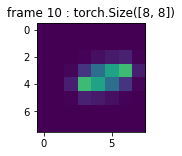

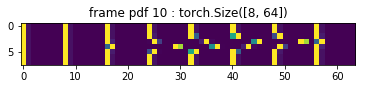

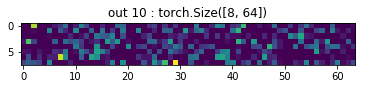

epoch 999:	loss 0.03744203969836235
epoch 1999:	loss 0.021651770919561386
epoch 2999:	loss 0.014965665526688099
epoch 3999:	loss 0.01166677474975586
epoch 4999:	loss 0.009873498231172562
epoch 5999:	loss 0.008976330049335957
epoch 6999:	loss 0.008438343182206154
epoch 7999:	loss 0.007919249124825
epoch 8999:	loss 0.007549745962023735
epoch 9999:	loss 0.007298314478248358


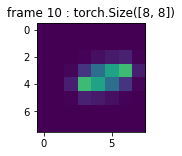

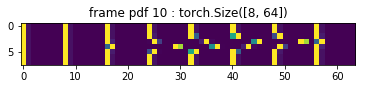

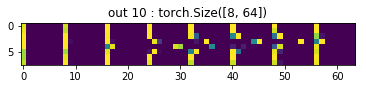

frames_pdf  torch.Size([100, 8, 64])
h  torch.Size([100, 4, 3, 3])


In [90]:
# Layer 1 autoencoder
resolution = 8
frames1 = generate_frames1(8, 8)
layer1 = Layer()
epochs = 10000 if device == "cuda" else 10000
a = 2

layer1.train(frames1, resolution, out_channels=a**2, epochs=epochs, kernel_size=4)

--------------------------------
Training with frames  torch.Size([100, 6, 6])
frames_pdf  torch.Size([100, 6, 48])
z  torch.Size([100, 36])
self.height * self.width * self.resolution  288


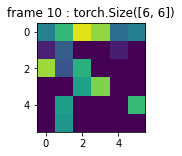

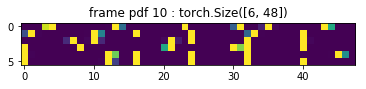

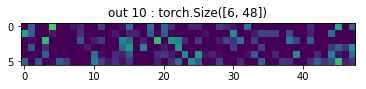

epoch 999:	loss 0.051108743995428085
epoch 1999:	loss 0.02782553993165493
epoch 2999:	loss 0.018772421404719353
epoch 3999:	loss 0.014873762615025043
epoch 4999:	loss 0.01283378154039383
epoch 5999:	loss 0.011611870490014553
epoch 6999:	loss 0.010716754011809826
epoch 7999:	loss 0.01001899316906929
epoch 8999:	loss 0.009590103290975094
epoch 9999:	loss 0.009400046430528164


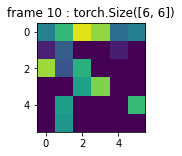

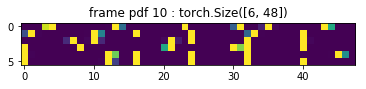

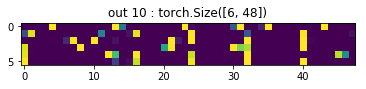

frames_pdf  torch.Size([100, 6, 48])
h  torch.Size([100, 9, 2, 2])


In [126]:
# Assume input (samples, feature maps, height, width) and that 
# features maps is a perfect squere, e.g. 9, of an integer 'a', e.g. 3 in this case
# Output (samples, height * a, width * a)
def flatten_feature_maps(f):
    s = f.shape
    f = f.permute(0, 2, 3, 1) # move features to the end
    s = f.shape
    a = int(s[3] ** 0.5)  # feature maps are at pos 3 now that we want to first split into a square of size (a X a)
    assert a * a == s[3], "Feature map count must be a perfect square"
    f = f.view(s[0], s[1], s[2], a, a)
    f = f.permute(0, 1, 3, 2, 4).contiguous() # frame count, height, sqr(features), width, sqr(features)
    s = f.shape
    f = f.view(s[0], s[1] * s[2], s[3] * s[4]) # each point becomes a square of features
    return f, a

# Layer 2 autoencoder
layer2 = Layer()
f, a = flatten_feature_maps(layer1.hidden_state)
layer2.train(f, resolution, out_channels=(a+1)**2, epochs=epochs, kernel_size=4)

--------------------------------
Training with frames  torch.Size([50, 6, 6])
frames_pdf  torch.Size([50, 6, 48])
z  torch.Size([50, 64])
self.height * self.width * self.resolution  288


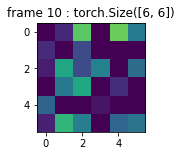

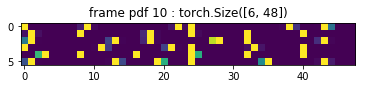

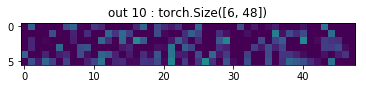

epoch 199:	loss 0.09906333684921265
epoch 399:	loss 0.07081414014101028
epoch 599:	loss 0.05699486285448074
epoch 799:	loss 0.04666639491915703
epoch 999:	loss 0.038456059992313385
epoch 1199:	loss 0.031794045120477676
epoch 1399:	loss 0.02631179802119732
epoch 1599:	loss 0.02174377627670765
epoch 1799:	loss 0.017894305288791656
epoch 1999:	loss 0.014622598886489868


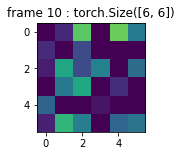

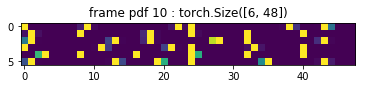

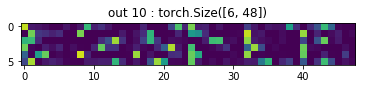

frames_pdf  torch.Size([50, 6, 48])
h  torch.Size([50, 16, 2, 2])


In [4]:
# Layer 3 autoencoder
layer3 = Layer()
f, a = flatten_feature_maps(layer2.hidden_state)
layer3.train(f, resolution, out_channels=(a+1)**2, epochs=epochs, kernel_size=4)

In [116]:
from scipy import stats

def sample_from_frame_pdf(mu_bar):
    assert len(mu_bar.shape) == 3
    
    # reshape mu_pdf from (frame count, height, width*resolution) into (frame count*height*width, resolution)
    s = mu_bar.shape
    mu_pdf = mu_bar.view(s[0], s[1], int(s[2] / resolution), resolution)
    s = mu_pdf.shape
    mu_pdf = mu_pdf.view(s[0] * s[1] * s[2], s[3])

    # sample single value from each distributions into (frame count*height*width, 1)
    sample = torch.Tensor([sample_from_pdf(item.numpy()) for item in mu_pdf])
    
    # reshape back into (frame count, height, width)
    sample = sample.view(s[0], s[1], s[2])

    return sample
    
def sample_from_pdf(mu_pdf):
    assert mu_pdf.shape == (resolution, )

    pk = mu_pdf.copy()
    xk = np.arange(resolution)
    pk[pk<0] = 0
    sum_pk = sum(pk)
    if sum(pk) > 0:
        pk = pk / sum_pk
        custm = stats.rv_discrete(name='custm', values=(xk, pk))
        value = custm.rvs(size=1) / resolution
        # apply scale (conflates value and confidence!)
        value = value * sum_pk
        return value
    else:
        return [0]


mu1 shape torch.Size([1, 8, 8])


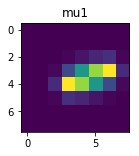

mu_pdf1 shape torch.Size([1, 8, 64])


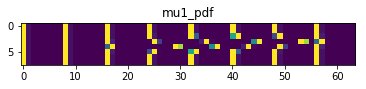

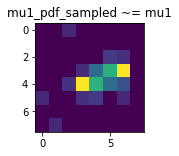

h1 shape torch.Size([1, 4, 3, 3])
mu_bar1 shape torch.Size([1, 8, 64])


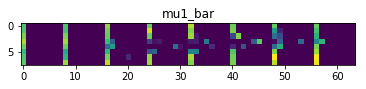

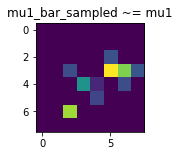

mu2 shape torch.Size([100, 6, 6])


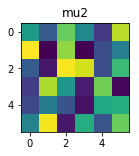

mu_pdf2 shape torch.Size([100, 6, 48])


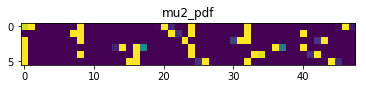

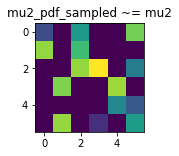

h2 shape torch.Size([100, 9, 2, 2])
mu_bar2 shape torch.Size([100, 6, 48])


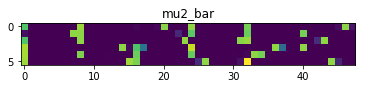

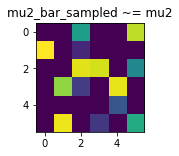

RuntimeError: size mismatch, m1: [6 x 6], m2: [36 x 512] at /Users/soumith/miniconda2/conda-bld/pytorch_1532623076075/work/aten/src/TH/generic/THTensorMath.cpp:2070

In [142]:
image_index = 10
mu1 = frames1[image_index].unsqueeze(dim=0)

def forward(mu, layer, layer_index):
    print(f"mu{layer_index} shape {mu.shape}")

    show_image(mu[0], title=f"mu{layer_index}")
    mu_pdf = NormalDistributionCollection.to_pdf(mu)
    print(f"mu_pdf{layer_index} shape {mu_pdf.shape}")

    show_image(mu_pdf[0], title=f"mu{layer_index}_pdf")
    mu_pdf_sampled = sample_from_frame_pdf(mu_pdf.detach())[0]
    show_image(mu_pdf_sampled, title=f"mu{layer_index}_pdf_sampled ~= mu{layer_index}")

    # Layer
    h = layer.model.encoder(mu_pdf)
    print(f"h{layer_index} shape {h.shape}")
    mu_bar = layer.model.decoder(h)
    print(f"mu_bar{layer_index} shape {mu_bar.shape}")

    show_image(mu_bar[0].detach().numpy(), title=f"mu{layer_index}_bar")
    mu_bar_sampled = sample_from_frame_pdf(mu_bar.detach())[0]
    show_image(mu_bar_sampled, title=f"mu{layer_index}_bar_sampled ~= mu{layer_index}")
    
    return mu_bar_sampled

# Layer 1
forward(mu1, layer1, 1)    

# Layer 2
h1, _ = flatten_feature_maps(layer1.hidden_state)
mu2 = h1.detach()
mu2_bar_sampled = forward(mu2, layer2, 2)

# mu2_bar_sampled decoded by layer 1 should reproduce mu1
mu_bar = layer1.model.decoder(mu2_bar_sampled)
mu_bar = unflatten_feature_maps(mu_bar) ### TODO
show_image(mu_bar)